In [ ]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

### 1. Data set
Load the dataset and select 100.000 examples for training and 1.000 for testing. <br>
Create a function that converts the genomic data into a one-hot encoded vector.

In [ ]:
batch_size = 20

# Load the data
data_train, data_test = tfds.load("genomics_ood", as_supervised=True, split=["train[:100000]", "test[:1000]"])

def onehotify(genome, label):
  """ Turns the genome tensor and the label tensor into a onehot notation.

  Args:
    genome (tensor): String tensor containing the genome sequence
    label (tensor): int tensor containing the label for the bacteria

  Returns:
    tensor: The genome tensor in a onehot notation, with a dtype of int (length=4)
    tensor: The label tensor in a onehot notation, with a dtype of int (length=10)
  """
  # Replace the base-letters with unique numbers in the whole tensor
  vocab = {"A": "0", "C": "1", "G": "2", "T": "3"}
  for key in vocab.keys():
    genome = tf.strings.regex_replace(genome, key, vocab[key])

  # Turn the genome numbers into onehot notations
  genome = tf.strings.bytes_split(genome)
  genome = tf.cast(tf.strings.to_number(genome), tf.uint8)
  genome = tf.one_hot(genome, 4)
  genome = tf.reshape(genome, (-1,))

  # Turn the label numbers into onehot notations
  label = tf.one_hot(label, 10)  
  label = tf.reshape(label, (-1,))


  return (genome, label)

# Apply the onehotify function to the training data, let it cache its results after
# use and prefetch data from it to reduce runtime. Set the batchsize to 128 and shuffle 
# the data
data_train = data_train.map(onehotify, num_parallel_calls=tf.data.experimental.AUTOTUNE)
data_train = data_train.cache()
data_train = data_train.prefetch(tf.data.experimental.AUTOTUNE)
data_train = data_train.batch(batch_size)
data_train = data_train.shuffle(buffer_size=batch_size)

# Do the same for the test data
data_test = data_test.map(onehotify, num_parallel_calls=tf.data.experimental.AUTOTUNE)
data_test = data_test.cache()
data_test = data_test.prefetch(tf.data.experimental.AUTOTUNE)
data_test = data_test.batch(batch_size)
data_test = data_test.shuffle(buffer_size=batch_size)



### 2. Model
Create a model for the genomic ANN with two hidden layers (256 units each) and 10 output units.

In [ ]:
# Clear previous keras data
tf.keras.backend.clear_session()

# Init hyperparameters
epochs = 10
learning_rate = 0.1

# Create the keras model. (A sequential model is effectively a MLP)
# The first layer will be a Reshape which is necessary because, keras otherwise
# thinks that the data doesnt have a complete shape yet (which is kind of true
# because it is not fully computed yet)
# Following are two dense layers with 256 units each using the sigmoid as activation.
# Lastly there is another dense layer with 10 units and a softmax for output.
model = tf.keras.models.Sequential([tf.keras.layers.Reshape((1000,)), 
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.sigmoid),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.sigmoid),
                                    tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)])

### 3. Training
Train the network for 10 epochs using a learning rate of 0.1. <br>
The loss function will be categorical cross entropy. <br>
It will be optimized using Standard gradient descent.

In [ ]:
# Init the optimizer (with nesterov-momentum, which means that a certain percentage
# of the last gradient will be added to each gradient.)
optimizer = tf.keras.optimizers.SGD(lr=learning_rate, momentum=0.7, nesterov=False)

# Set the loss function and optimizer for the model and add accuracy to the metrics
model.compile(loss="categorical_crossentropy", optimizer = optimizer, metrics=["accuracy"])

# Get the initial loss and accuracies for both data sets
init_train_metrics = model.evaluate(data_train, verbose=0)
init_test_metrics = model.evaluate(data_test, verbose=0)

# Train the model
history = model.fit(data_train, validation_data = data_test, epochs=epochs, shuffle=True, batch_size= 64)



Epoch 1/10
5000/5000 [==============================] - 13s 3ms/step - loss: 1.5352 - accuracy: 0.3380 - val_loss: 1.5099 - val_accuracy: 0.3300
Epoch 2/10
5000/5000 [==============================] - 12s 2ms/step - loss: 1.4843 - accuracy: 0.3578 - val_loss: 1.4866 - val_accuracy: 0.3560
Epoch 3/10
5000/5000 [==============================] - 13s 3ms/step - loss: 1.4738 - accuracy: 0.3627 - val_loss: 1.4736 - val_accuracy: 0.3600
Epoch 4/10
5000/5000 [==============================] - 14s 3ms/step - loss: 1.4620 - accuracy: 0.3682 - val_loss: 1.4394 - val_accuracy: 0.3790
Epoch 5/10
5000/5000 [==============================] - 13s 3ms/step - loss: 1.4377 - accuracy: 0.3818 - val_loss: 1.4066 - val_accuracy: 0.3930
Epoch 6/10
5000/5000 [==============================] - 13s 3ms/step - loss: 1.4056 - accuracy: 0.3981 - val_loss: 1.3919 - val_accuracy: 0.3970
Epoch 7/10
5000/5000 [==============================] - 13s 3ms/step - loss: 1.3742 - accuracy: 0.4131 - val_loss: 1.4086 - val_ac

In [ ]:
init_train_metrics

[2.5115127563476562, 0.10424000024795532]

### 4. Visualization

Visualise accuracy and loss for training and test data.

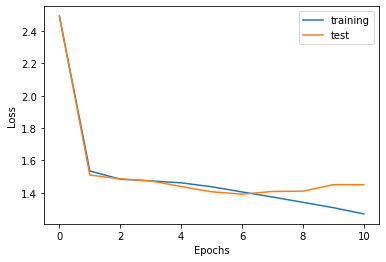

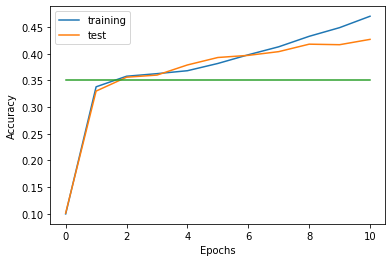

In [ ]:
# Combine the losses and averages while training with the ones before training
train_loss = np.concatenate(([init_train_metrics[0]], history.history["loss"]))
train_acc = np.concatenate(([init_train_metrics[1]], history.history["accuracy"]))

test_loss = np.concatenate(([init_test_metrics[0]], history.history["val_loss"]))
test_acc = np.concatenate(([init_test_metrics[1]], history.history["val_accuracy"]))

# draw the loss plot
plt.figure()
line1, = plt.plot(train_loss)
line2, = plt.plot(test_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend((line1, line2), ("training", "test"))
plt.show()

# draw the accuracy plot
plt.figure()
line1, = plt.plot(train_acc)
line2, = plt.plot(test_acc)
line3, = plt.plot([0.35] * (epochs + 1))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend((line1, line2), ("training", "test"))
plt.show()